# Food Vision Project

## Check GPU

To use [mixed precision](https://www.tensorflow.org/guide/mixed_precision) We need to have compatible gpu. GPUs with compute 7.0 or higher can take the most benefit out of mixed precision. The code will run on any hardware but it will not get the benefit of faster training

Google colab offers Tesla T4 which is compatible with mixed precision, however google colab also offers
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f21c04aa-1836-4308-0fa2-6f75ba9bf8cb)


If you don't get the Tesla T4 on the first try. Try disconnecting your runtime and connecting again. Google gives hardware randomly so you might get one

## Getting helper function

In [105]:
!wget https://raw.githubusercontent.com/Rafayqayyum/food_vision/main/helper_functions.py

--2022-08-05 17:49:35--  https://raw.githubusercontent.com/Rafayqayyum/food_vision/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6900 (6.7K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.74K  --.-KB/s    in 0s      

2022-08-05 17:49:35 (85.2 MB/s) - ‘helper_functions.py’ saved [6900/6900]



In [6]:
# Importing the helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

## Using Tensorflow datasets to download our data

Tensorflow datasets can be found here: https://www.tensorflow.org/datasets

In [7]:

import tensorflow as tf
import tensorflow_datasets as tfds


(train_data,test_data),ds_info=tfds.load('food101',
                                         split=['train','validation'],
                                         shuffle_files=True, #shuffles the tensors
                                         as_supervised=True, #data gets returned in tuple format(data,label)
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete00HZWD/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete00HZWD/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from tensorflow dataset


In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names=ds_info.features['label'].names

In [10]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the training data
train_one_sample=train_data.take(1)

In [12]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# output info about our training sample
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from food101 (tensor form) :{label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from food101 (tensor form) :18,
  Class name (str form): chicken_curry
  


* Target class shows that the labels are not one hot encoded but in the form of 1,2,3,4 so we might need to use sparse_categorical_crossentropy.

* The datatype if also uint8 so we might need to change it

* If you check more images here you'll realize that the images are of different shape so we might need to set them to same shape

In [14]:
# What are the min and max values of our image tensor
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

This tells us that our data might need to be preprocessed if we are using a model without preprocessing layers

## Plot an image from dataset

Text(0.5, 1.0, 'chicken_curry')

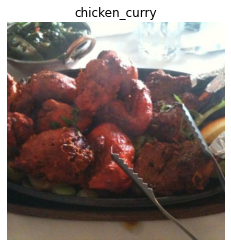

In [15]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False)
plt.title(class_names[label.numpy()])

## Creating Preprocessing function for data

What we know about data:
* In `uint8` datatype
* Comprised of all different size tensors(different size images)
* Not scaled ( the pixel values are between 0 & 255)
* Dataset in batches

What we know about NN:
* Data in `float32` dtype (or mixed precision `float16` and `float32`)
* Data should be in same size
* Scaled data (values between 0 & 1)  
* Data in batches

Since we will be using efficientnet we dont need to rescale 

In [16]:
def preprocess_image(image,label,img_shape=224):
  image=tf.image.resize(image,size=[img_shape,img_shape])
  return tf.cast(image,tf.float32),label # return a tuple of image and label

In [17]:
# Process a single sample image

preprocessed_image=preprocess_image(image,label)[0]
print(f'Image before preprocessing\n Shape: {image.shape},\nDatatype: {image.dtype}')
print(f'Image before preprocessing\n Shape: {preprocessed_image.shape},\nDatatype: {preprocessed_image.dtype}')

Image before preprocessing
 Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image before preprocessing
 Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

To deal with large amounts of data, the input pipeline should be fast. Here parallelization is being used with prefetching to process data faster. Otherwise, the model would've taken 11-12 minutes per epoch

For more resources on this, I'd highly recommend reading:  https://www.tensorflow.org/guide/data_performance

What we are doing here?

* Mapping preprocessing function to our dataset using parallelization
* Shuffling the training dataset
* Batching the dataset
* Prefetching the dataset


In [18]:
train_data=train_data.map(preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data=test_data.map(preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

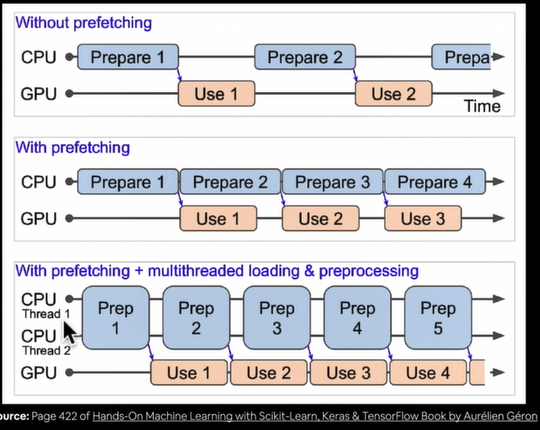

## Creating modelling callbacks

We want the training logs of the models saved so we can explore them later and the model being checkpointed so the progress is saved since the model is fairly large. Creating the following callbacks:

* TensorBoard callback to log training results
* ModelCheckpoint callbacks to save our model's progess after feature extraction

In [20]:
# create tensorboard callback (import from helper function)
from helper_functions import create_tensorboard_callback

# ModelCheckPoint calllback to save the progress
checkpoint_path='model_checkpoints/cp.ckpt'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    metric='val_acc',
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbosre=0)

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the guide: https://www.tensorflow.org/guide/mixed_precision

Our GPUs have limited amount of memory. Mixed precision allows us to use both float16 and float32 which saves some space and allows more data to be loaded into the memory. Also, gpus have specialized hardware that allows 16bit to be computed faster

In [21]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature Extraction model

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer

inputs=layers.Input(shape=input_shape,name='Input_layer')

#Note: EfficientNetBX models have rescaling built-in but if your model doesn't have it
#x = preprocessing.Rescaling(1/255.)(x)

x=base_model(inputs,training=False)

x=layers.GlobalAveragePooling2D()(x)

x=layers.Dense(len(class_names))(x)
outputs=layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

model=tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policy

In [25]:
for i,layer in enumerate(model.layers):
  print(f'{i} {layer.name} {layer.trainable} {layer.dtype_policy}')

0 Input_layer True <Policy "float32">
1 efficientnetb0 False <Policy "mixed_float16">
2 global_average_pooling2d True <Policy "mixed_float16">
3 dense True <Policy "mixed_float16">
4 softmax_float32 True <Policy "float32">


In [26]:
for i,layer in enumerate(model.layers[1].layers):
  print(f'{i} {layer.name} {layer.trainable} {layer.dtype_policy}')

0 input_1 False <Policy "float32">
1 rescaling False <Policy "mixed_float16">
2 normalization False <Policy "mixed_float16">
3 stem_conv_pad False <Policy "mixed_float16">
4 stem_conv False <Policy "mixed_float16">
5 stem_bn False <Policy "mixed_float16">
6 stem_activation False <Policy "mixed_float16">
7 block1a_dwconv False <Policy "mixed_float16">
8 block1a_bn False <Policy "mixed_float16">
9 block1a_activation False <Policy "mixed_float16">
10 block1a_se_squeeze False <Policy "mixed_float16">
11 block1a_se_reshape False <Policy "mixed_float16">
12 block1a_se_reduce False <Policy "mixed_float16">
13 block1a_se_expand False <Policy "mixed_float16">
14 block1a_se_excite False <Policy "mixed_float16">
15 block1a_project_conv False <Policy "mixed_float16">
16 block1a_project_bn False <Policy "mixed_float16">
17 block2a_expand_conv False <Policy "mixed_float16">
18 block2a_expand_bn False <Policy "mixed_float16">
19 block2a_expand_activation False <Policy "mixed_float16">
20 block2a_dwco

## Compile the Model

In [27]:
 #loss=tf.keras.losses.sparse_categorical_crossentropy because labels in integers
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## Fit the model

In [28]:
initial_epochs=3
history0=model.fit(train_data,
          epochs=initial_epochs,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name='food vision',
                                                 experiment_name='Feature_extraction'),
                     model_checkpoint])

Saving TensorBoard log files to: food vision/Feature_extraction/20220805-162256
Epoch 1/3
2368/2368 [==============================] - 194s 74ms/step - loss: 1.8222 - accuracy: 0.5550 - val_loss: 1.2287 - val_accuracy: 0.6780
Epoch 2/3
2368/2368 [==============================] - 171s 72ms/step - loss: 1.2952 - accuracy: 0.6656 - val_loss: 1.1160 - val_accuracy: 0.7023
Epoch 3/3
2368/2368 [==============================] - 172s 72ms/step - loss: 1.1429 - accuracy: 0.7017 - val_loss: 1.0906 - val_accuracy: 0.7100


## Evaluate the model

In [29]:
model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.0893 - accuracy: 0.7082


[1.0893303155899048, 0.7081980109214783]

## Save the whole model locally

In [30]:
model.save('savedModel/mymodel')

INFO:tensorflow:Assets written to: savedModel/mymodel/assets


INFO:tensorflow:Assets written to: savedModel/mymodel/assets


In [31]:
model_loaded=tf.keras.models.load_model('savedModel/mymodel')

In [32]:
model_loaded.evaluate(test_data)

790/790 [==============================] - 51s 63ms/step - loss: 1.0893 - accuracy: 0.7082


[1.0893300771713257, 0.7081980109214783]

In [33]:
for layer in model_loaded.layers:
  print(layer.name,layer.dtype_policy,layer.trainable)

Input_layer <Policy "float32"> True
efficientnetb0 <Policy "mixed_float16"> False
global_average_pooling2d <Policy "mixed_float16"> True
dense <Policy "mixed_float16"> True
softmax_float32 <Policy "float32"> True


## Creating callbacks before Performing fine tuning

In [34]:
#checkpoint
checkpoint_path='fine_tune/cp.ckpt'
checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True,
                                              save_weights_only=True)


# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


## Perform the Fine tuning on the model

We are unfreezeing all of the layers because we have enough data. If we were working with low amount of data we should've unfroozen lesser (10,20) layers. 

In [35]:
#setting all the layers to trainable
for layer in model.layers:
  layer.trainable=True

In [36]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype_policy)

Input_layer True <Policy "float32">
efficientnetb0 True <Policy "mixed_float16">
global_average_pooling2d True <Policy "mixed_float16">
dense True <Policy "mixed_float16">
softmax_float32 True <Policy "float32">


In [37]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype_policy)

input_1 True <Policy "float32">
rescaling True <Policy "mixed_float16">
normalization True <Policy "mixed_float16">
stem_conv_pad True <Policy "mixed_float16">
stem_conv True <Policy "mixed_float16">
stem_bn True <Policy "mixed_float16">
stem_activation True <Policy "mixed_float16">
block1a_dwconv True <Policy "mixed_float16">
block1a_bn True <Policy "mixed_float16">
block1a_activation True <Policy "mixed_float16">
block1a_se_squeeze True <Policy "mixed_float16">
block1a_se_reshape True <Policy "mixed_float16">
block1a_se_reduce True <Policy "mixed_float16">
block1a_se_expand True <Policy "mixed_float16">
block1a_se_excite True <Policy "mixed_float16">
block1a_project_conv True <Policy "mixed_float16">
block1a_project_bn True <Policy "mixed_float16">
block2a_expand_conv True <Policy "mixed_float16">
block2a_expand_bn True <Policy "mixed_float16">
block2a_expand_activation True <Policy "mixed_float16">
block2a_dwconv_pad True <Policy "mixed_float16">
block2a_dwconv True <Policy "mixed_f

In [38]:
## recompiling the model

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
history1=model.fit(train_data,
                   epochs=100,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=int(0.15*len(test_data)),
                   initial_epoch=history0.epoch[-1],
                   callbacks=[create_tensorboard_callback(dir_name='food vision',
                                                          experiment_name='fine_tuning'),
                              checkpoint,
                              early_stopping,
                              reduce_lr])

Saving TensorBoard log files to: food vision/fine_tuning/20220805-163425
Epoch 3/100
2368/2368 [==============================] - 352s 142ms/step - loss: 0.9218 - accuracy: 0.7520 - val_loss: 0.8360 - val_accuracy: 0.7595 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 336s 141ms/step - loss: 0.5763 - accuracy: 0.8400 - val_loss: 0.7977 - val_accuracy: 0.7855 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.3308 - accuracy: 0.9060 - val_loss: 0.9087 - val_accuracy: 0.7770 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9483
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 335s 141ms/step - loss: 0.1748 - accuracy: 0.9483 - val_loss: 0.9431 - val_accuracy: 0.7741 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - 337s 142ms/step - loss: 0.0368 - accuracy:

In [40]:
model.evaluate(test_data)

790/790 [==============================] - 48s 60ms/step - loss: 1.0552 - accuracy: 0.7963


[1.0552220344543457, 0.7962772250175476]

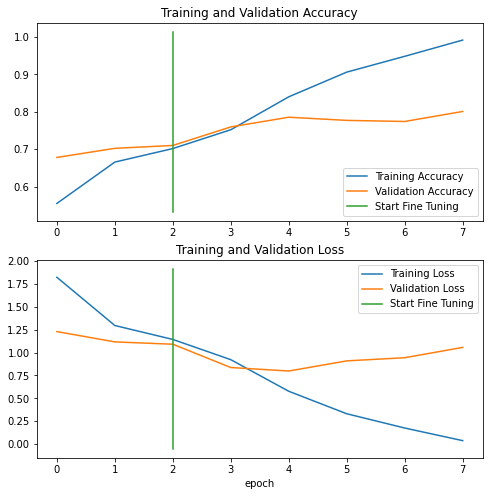

In [41]:
compare_historys(history0,history1,3)

In [42]:
model.save('savedModel/Fine_tuned/')

INFO:tensorflow:Assets written to: savedModel/Fine_tuned/assets


INFO:tensorflow:Assets written to: savedModel/Fine_tuned/assets


## Evaluating Fine Tuned model

In [43]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_data:
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

### Creating a Classification report

In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       250
           1       0.76      0.77      0.77       250
           2       0.86      0.86      0.86       250
           3       0.87      0.78      0.82       250
           4       0.75      0.72      0.73       250
           5       0.70      0.68      0.69       250
           6       0.89      0.81      0.85       250
           7       0.90      0.92      0.91       250
           8       0.59      0.64      0.61       250
           9       0.77      0.70      0.73       250
          10       0.73      0.74      0.73       250
          11       0.91      0.78      0.84       250
          12       0.88      0.84      0.86       250
          13       0.72      0.82      0.77       250
          14       0.76      0.79      0.78       250
          15       0.70      0.63      0.66       250
          16       0.65      0.69      0.67       250
          17       0.86    

### Creating a confusion matrix

In [107]:
from helper_functions import make_confusion_matrix

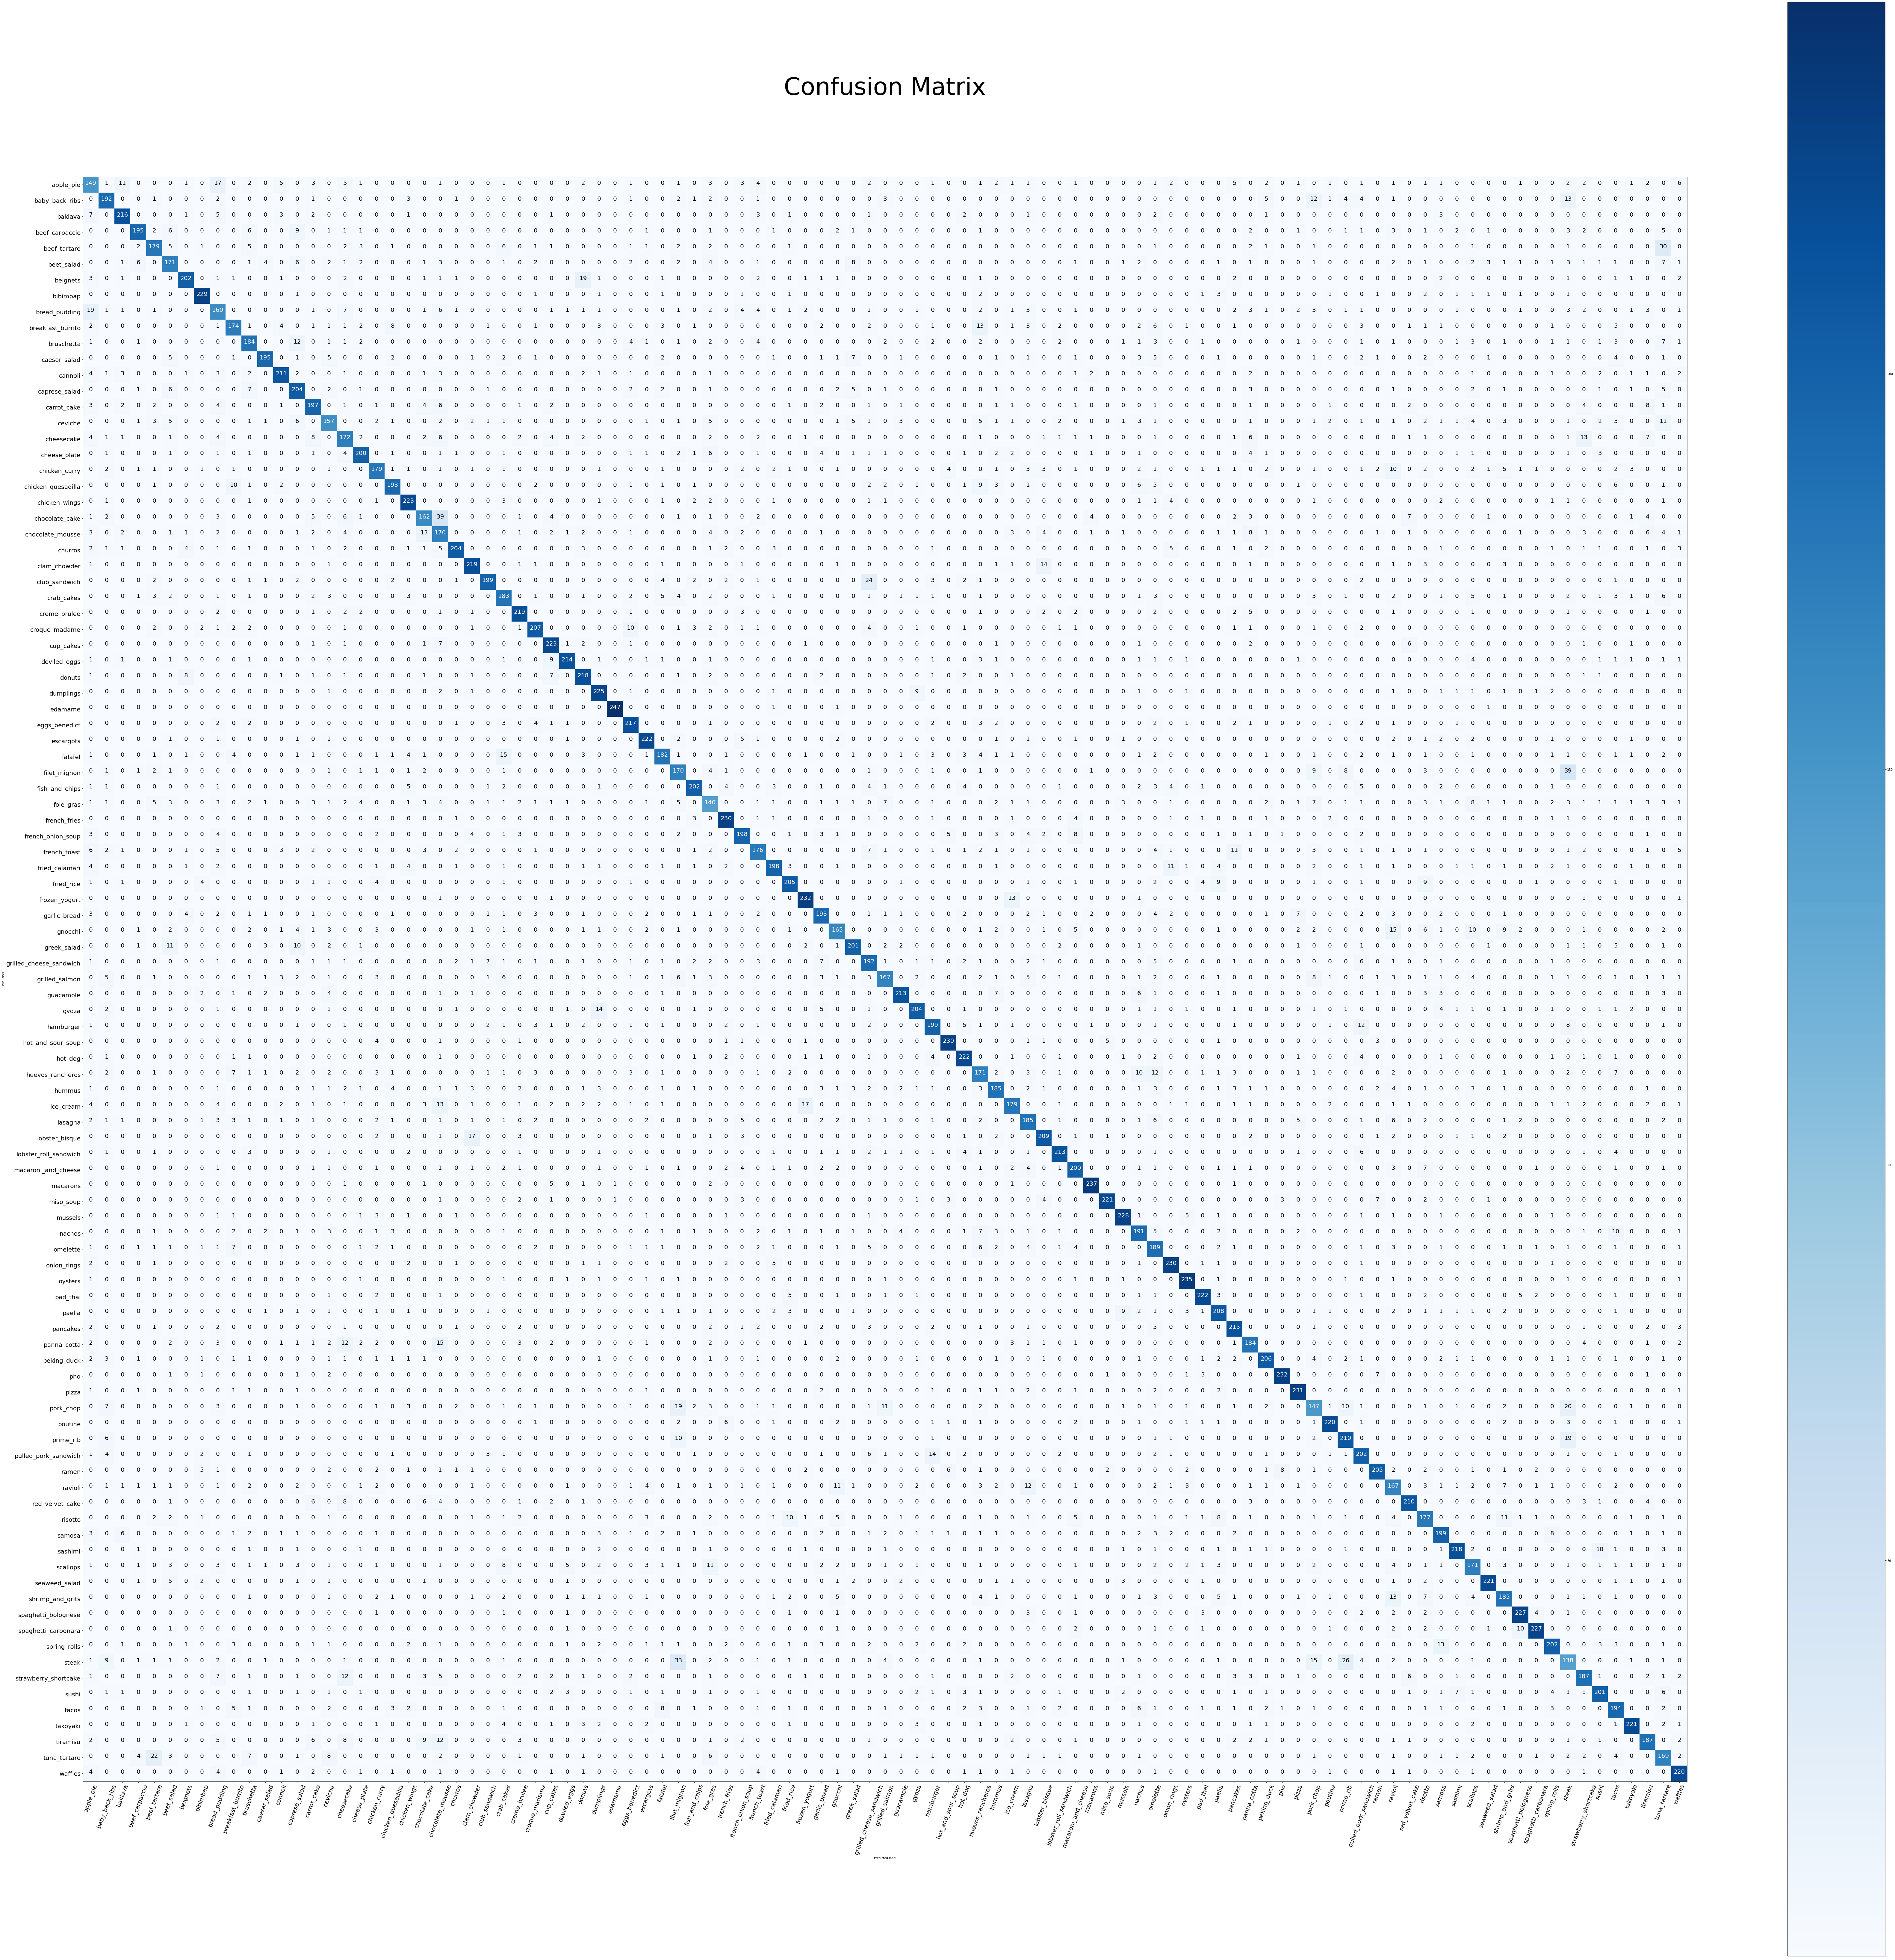

In [108]:
make_confusion_matrix(correct_labels,predicted_labels,
                      classes=class_names,
                      figsize=(120,120),text_size=20,savefig=False)

### Plotting F1-scores

In [69]:
classification_report_dict=classification_report(correct_labels,predicted_labels,output_dict=True)

In [70]:
f1_scores={}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    #add class names and f1_scores to new dict
    f1_scores[class_names[int(k)]]=v['f1-score']

In [71]:
#turn f1-score to dataframe
import pandas as pd
f1_scores_df=pd.DataFrame({'class_names':list(f1_scores.keys()),
                           'f1-score':list(f1_scores.values())}).sort_values('f1-score',ascending=False)

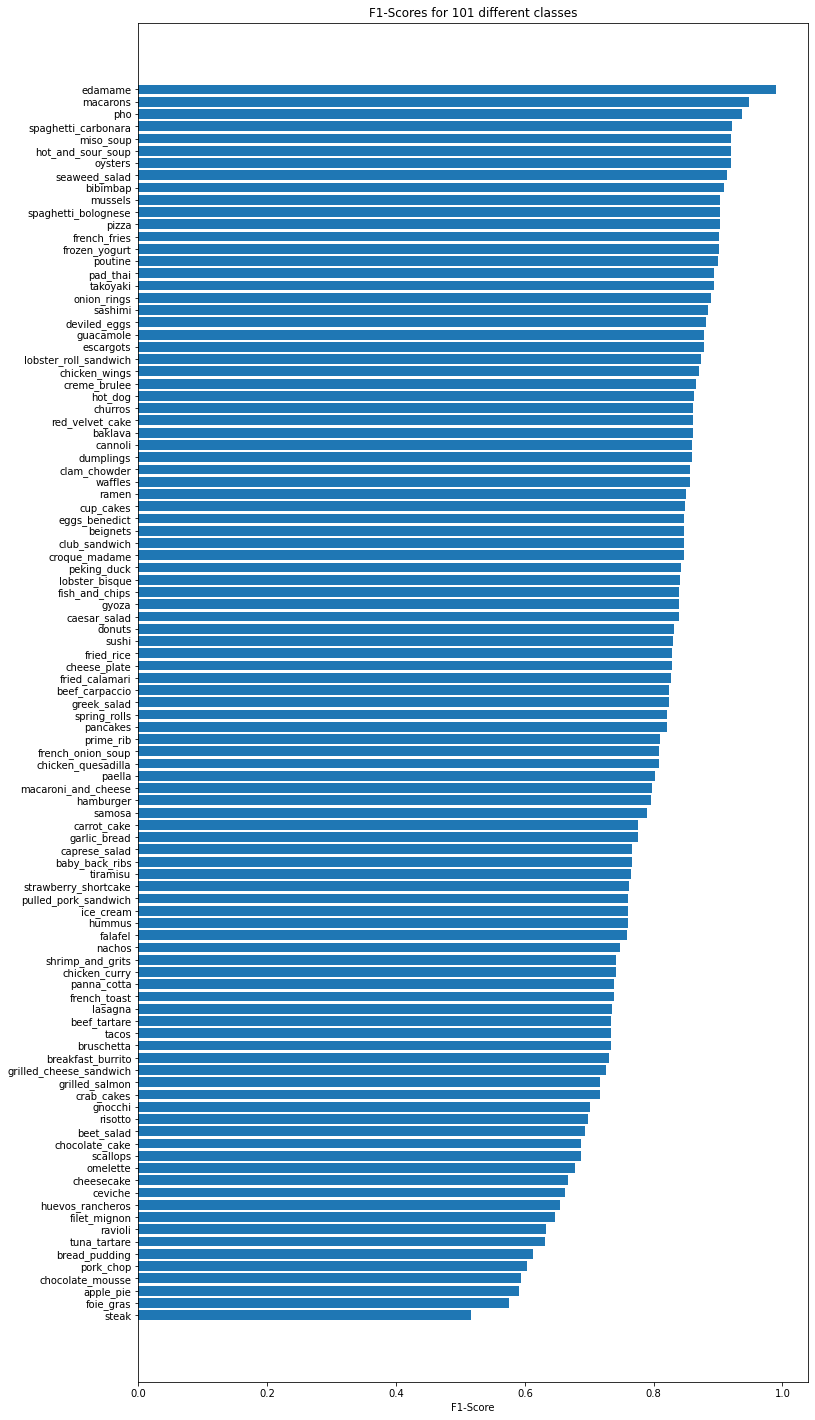

In [72]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(12,25))
#creates bar chart
scores=ax.barh(range(len(f1_scores_df)),f1_scores_df['f1-score'].values)
#sets no of ticks
ax.set_yticks(range(len(f1_scores_df)))
#sets labels for ticks
a=ax.set_yticklabels(f1_scores_df['class_names'])

ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores for 101 different classes')
#invert the ais
ax.invert_yaxis()

### Visualizing Random images from the dataset

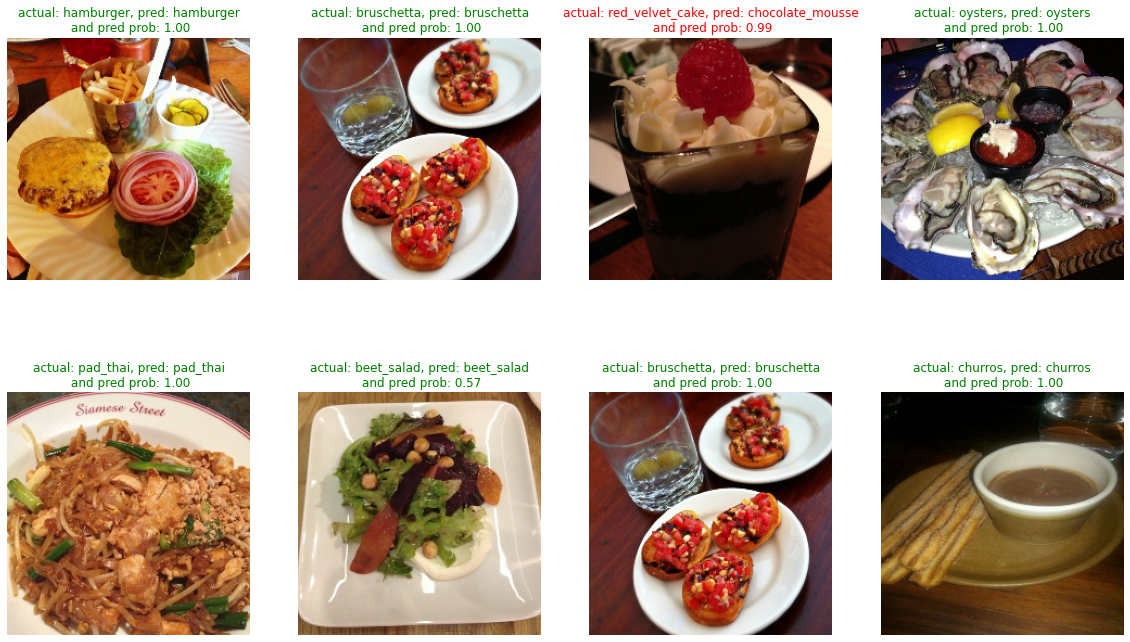

In [73]:
import random
plt.figure(figsize=(20,25))
random_choices=(random.randint(0,31) for _ in range(8))
for img,label in test_data.take(1):
  for j,i in enumerate(random_choices):

    pred_prob=model.predict(tf.expand_dims(img[i],axis=0))
    pred_class=class_names[pred_prob.argmax()]
    class_name=class_names[label[i]]

    #plot image
    plt.subplot(4,4,j+1)
    plt.imshow(img[i]/255.)  #matplotlib needs normalized images
    if class_name==pred_class:
      title_color='g'
    else:
      title_color='r'
    plt.title(f'actual: {class_name}, pred: {pred_class}\n and pred prob: {pred_prob.max():.2f}',c=title_color)
    plt.axis(False)